# References
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

# Import packages 

In [34]:
!pip install spacy
!pip install nltk
!pip install gensim
!python -m spacy download en_core_web_sm 
!pip install wordcloud
!pip install pyLDAvis
# os
import os 

# Pandas
import pandas as pd

# Spacy
import spacy
from spacy.lang.en import English

# NLTK
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')

# Gensim
import gensim
from gensim import corpora

# Numpy
import numpy as np

# Pickle
import pickle

# Itertools
import itertools

# Util
import random
spacy.load('en_core_web_sm')
parser = English()

# Set up log to terminal
import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# # Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive as ggdrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# gdrive = ggdrive(gauth)

# from google.colab import drive as colabdrive
# colabdrive.mount('/content/gdrive')

nltk.download('wordnet')

wnLemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

parser = English()

     |████████████████████████████████| 13.9 MB 3.6 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read and write functions

#### Read CSV into DataFrame

In [16]:
def read_data(file_name, nrows=None):
    if isinstance(file_name, list):
        data = pd.DataFrame()
        for file in file_name:
            chunk = pd.read_csv(file, nrows=nrows)
            data = data.append(chunk, ignore_index=True)
    else:
        data = pd.read_csv(file_name, nrows=nrows)
    return data

#### Read CSV into DataFrame (Google Drive)

In [17]:
def read_data_ggdrive(file_name, file_id):
    print(f'Start reading file {file_name}')
    downloaded = ggdrive.CreateFile({'id':file_id}) 
    downloaded.GetContentFile(file_name)  
    data = pd.read_csv(file_name)
    print(f'Read {data.size} rows from file {file_name}')
    return data

In [18]:
def summary_data(data):
    print("# rows: ", data.size)
    data_left_leaning = data.loc[data['political_leaning'] == "LEFT"]
    print("# articles left leaning: ", data_left_leaning.size)

    data_right_leaning = data.loc[data['political_leaning'] == "RIGHT"]
    print("# articles right leaning: ", data_right_leaning.size)

    data_center_leaning = data.loc[data['political_leaning'] == "CENTER"]
    print("# articles center leaning: ", data_center_leaning.size)

    data_undefined_leaning = data.loc[data['political_leaning'] == "UNDEFINED"]
    print("# articles undefined leaning: ", data_center_leaning.size)


    total = data_left_leaning.size + data_right_leaning.size + data_center_leaning.size + data_undefined_leaning.size
    print("# total: ", total)

#### Funcs: Read corpus and dictionary from GG Drive and local file

In [19]:
def load_corpus(filename='', fileid="", ggdrive=None):
    if len(filename) == 0:
        raise Exception('invalid file name')
    if ggdrive is not None:
        if len(fileid) == 0:
            raise Exception('invalid file id')
        downloaded = ggdrive.CreateFile({'id':fileid}) 
        downloaded.GetContentFile(filename)  
    with open(filename, 'rb') as handle:
        corpus = pickle.load(handle)
    print(f'Corpus loaded from file {filename}')
    return corpus

def load_dictionary(filename='', fileid="", ggdrive=None):
    if len(filename) == 0:
        raise Exception('invalid file name')        
    if ggdrive is not None:    
        if len(fileid) == 0:
            raise Exception('invalid file id')
        downloaded = ggdrive.CreateFile({'id':fileid}) 
        downloaded.GetContentFile(filename)  
    dictionary = corpora.Dictionary.load(filename)
    print(f'Dictionary loaded from file {filename}')
    return dictionary

def load_model(filename='', fileid='', ggdrive=None):
    if len(filename) == 0:
        raise Exception('invalid file name')        
    if ggdrive is not None:    
        if len(fileid) == 0:
            raise Exception('invalid file id')
        downloaded = ggdrive.CreateFile({'id':fileid}) 
        downloaded.GetContentFile(filename)  
    model = gensim.models.ldamodel.LdaModel.load(filename)
    print(f'Model loaded from file {filename}')
    return model

# Load model, corpus and dictionary

In [9]:
# Model
model = load_model('task1_lda.gensim')

2022-02-06 23:30:20,126 : INFO : loading LdaModel object from task1_lda.gensim
2022-02-06 23:30:20,137 : INFO : loading expElogbeta from task1_lda.gensim.expElogbeta.npy with mmap=None
2022-02-06 23:30:21,341 : INFO : setting ignored attribute state to None
2022-02-06 23:30:21,342 : INFO : setting ignored attribute id2word to None
2022-02-06 23:30:21,342 : INFO : setting ignored attribute dispatcher to None
2022-02-06 23:30:21,343 : INFO : LdaModel lifecycle event {'fname': 'task1_lda.gensim', 'datetime': '2022-02-06T23:30:21.343353', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.117-58.216.amzn2.x86_64-x86_64-with-glibc2.31', 'event': 'loaded'}
2022-02-06 23:30:21,343 : INFO : loading LdaState object from task1_lda.gensim.state
2022-02-06 23:30:21,363 : INFO : loading sstats from task1_lda.gensim.state.sstats.npy with mmap=None
2022-02-06 23:30:23,551 : INFO : LdaState lifecycle event {'fname': 'tas

Model loaded from file task1_lda.gensim


In [10]:
# Corpus
corpus = load_corpus('Task1_corpus_full.pkl')

Corpus loaded from file Task1_corpus_full.pkl


In [12]:
# Dictionary
dictionary = load_dictionary('Task1_dictionary_full.gensim')

2022-02-06 23:31:19,749 : INFO : loading Dictionary object from Task1_dictionary_full.gensim
2022-02-06 23:31:20,204 : INFO : Dictionary lifecycle event {'fname': 'Task1_dictionary_full.gensim', 'datetime': '2022-02-06T23:31:20.204771', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.117-58.216.amzn2.x86_64-x86_64-with-glibc2.31', 'event': 'loaded'}


Dictionary loaded from file Task1_dictionary_full.gensim


# Simple printout

In [20]:
def print_topics(model, print_num_topics=15, print_num_words=4):
    topics = model.print_topics(num_topics=print_num_topics, num_words=print_num_words)
    print(f'Here are the top {print_num_topics} with #{print_num_words} words per topic')
    for topic in topics:
        print(topic)

In [21]:
print_topics(model, print_num_topics=100, print_num_words=10)

2022-02-06 23:33:03,508 : INFO : topic #0 (0.010): 0.082*"apple" + 0.062*"spanish" + 0.038*"carrie" + 0.034*"casino" + 0.032*"gates" + 0.031*"argentina" + 0.029*"spain" + 0.025*"swiss" + 0.024*"iphone" + 0.023*"vega"
2022-02-06 23:33:03,513 : INFO : topic #1 (0.010): 0.028*"people" + 0.026*"number" + 0.023*"report" + 0.022*"population" + 0.022*"increase" + 0.017*"accord" + 0.016*"years" + 0.015*"census" + 0.012*"since" + 0.012*"country"
2022-02-06 23:33:03,517 : INFO : topic #2 (0.010): 0.053*"right" + 0.027*"gender" + 0.027*"people" + 0.021*"religious" + 0.020*"discrimination" + 0.017*"freedom" + 0.017*"marriage" + 0.017*"lgbtq" + 0.017*"transgender" + 0.015*"identity"
2022-02-06 23:33:03,521 : INFO : topic #3 (0.010): 0.038*"president" + 0.036*"event" + 0.034*"first" + 0.023*"visit" + 0.018*"speech" + 0.014*"state" + 0.013*"washington" + 0.012*"attend" + 0.011*"photo" + 0.011*"former"
2022-02-06 23:33:03,525 : INFO : topic #4 (0.010): 0.165*"israel" + 0.063*"israeli" + 0.059*"jewish"

Here are the top 100 with #10 words per topic
(0, '0.082*"apple" + 0.062*"spanish" + 0.038*"carrie" + 0.034*"casino" + 0.032*"gates" + 0.031*"argentina" + 0.029*"spain" + 0.025*"swiss" + 0.024*"iphone" + 0.023*"vega"')
(1, '0.028*"people" + 0.026*"number" + 0.023*"report" + 0.022*"population" + 0.022*"increase" + 0.017*"accord" + 0.016*"years" + 0.015*"census" + 0.012*"since" + 0.012*"country"')
(2, '0.053*"right" + 0.027*"gender" + 0.027*"people" + 0.021*"religious" + 0.020*"discrimination" + 0.017*"freedom" + 0.017*"marriage" + 0.017*"lgbtq" + 0.017*"transgender" + 0.015*"identity"')
(3, '0.038*"president" + 0.036*"event" + 0.034*"first" + 0.023*"visit" + 0.018*"speech" + 0.014*"state" + 0.013*"washington" + 0.012*"attend" + 0.011*"photo" + 0.011*"former"')
(4, '0.165*"israel" + 0.063*"israeli" + 0.059*"jewish" + 0.056*"palestinian" + 0.028*"netanyahu" + 0.018*"benjamin" + 0.016*"jerusalem" + 0.016*"state" + 0.014*"minister" + 0.014*"semitism"')
(5, '0.024*"government" + 0.024*"austr

 # What is the Dominant topic and its percentage contribution in each document
 In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

NameError: name 'data' is not defined

In [ ]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

# Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

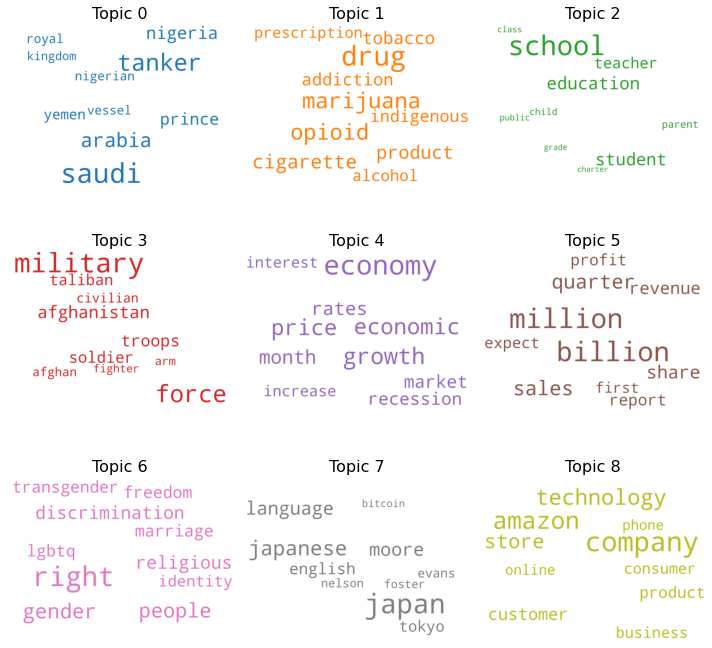

In [65]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(num_topics=9, num_words=10, formatted=False)
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
      
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# pyLDAVis
pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [37]:
# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary=model.id2word)
vis

KeyboardInterrupt: 

In [ ]:
pyLDAvis.save_html(vis, 'lda_visualiaztion_100_topics.html')